In [2]:
import numpy as np
import pickle

# Set random seed for reproducibility
np.random.seed(1337)

# Define paths
image_path = '/home/maria/Documents/HarvardData/Images'
session_ims = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/session_images.p','rb'))

# Construct full image paths
image_paths = np.array([f"{image_path}/{im.split('/')[2]}" for im in session_ims])

# Total number of images
n_total = len(session_ims)
print(f"Total number of images: {n_total}")

# Define the number of training samples
n_train = 1000

# Ensure that n_train does not exceed n_total
if n_train > n_total:
    raise ValueError("Number of training samples exceeds the total number of available images.")

# Randomly select unique training indices without replacement
training_path_inds = np.random.choice(n_total, size=n_train, replace=False)
training_paths = image_paths[training_path_inds]

# Determine test indices as those not in training_path_inds
test_inds = np.setdiff1d(np.arange(n_total), training_path_inds)
test_paths = image_paths[test_inds]

# Print shapes to verify
print(f"Training indices shape: {training_path_inds.shape}")  # Should be (1000,)
print(f"Number of test samples: {len(test_paths)}")           # Should be n_total - 1000

# Optional: Verify no overlap between training and test sets
overlap = np.intersect1d(training_paths, test_paths)
print(f"Number of overlapping images between training and test sets: {len(overlap)}")  # Should be 0

Total number of images: 1250
Training indices shape: (1000,)
Number of test samples: 250
Number of overlapping images between training and test sets: 0


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import pickle
import numpy as np

# Load data
dat = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/session_responses.p', 'rb'))
vit_train=np.load("Bo220226_training_set.npy")
vit_test=np.load("Bo220226_test_set.npy")
# Define the Mixture of Experts model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import pickle
import numpy as np

# Load data
dat = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/session_responses.p', 'rb'))
dino = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/dinov2_features.p', 'rb'))

# Define the Mixture of Experts model
class MixtureOfExperts(nn.Module):
    def __init__(self, input_size, num_experts, hidden_size, output_size):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # Define experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
            for _ in range(num_experts)
        ])
        # Define gating network
        self.gate = nn.Sequential(
            nn.Linear(input_size, num_experts),
            nn.Softmax(dim=1)  # Outputs weights for each expert
        )
    
    def forward(self, x):
        # Get expert predictions
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # Shape: [batch_size, num_experts, output_size]
        # Get gating weights
        gating_weights = self.gate(x)  # Shape: [batch_size, num_experts]
        # Combine expert outputs using gating weights
        out = torch.sum(gating_weights.unsqueeze(2) * expert_outputs, dim=1)  # Weighted sum, Shape: [batch_size, output_size]
        return out

# Preprocess data
X_train = torch.tensor(vit_train, dtype=torch.float32)  # Features
y_train = torch.tensor(dat[training_path_inds], dtype=torch.float32)  # Target with shape [n_samples, n_neurons]

X_test = torch.tensor(vit_test, dtype=torch.float32)  # Features
y_test = torch.tensor(dat[test_inds], dtype=torch.float32)  # Target with shape [n_samples, n_neurons]

# Hyperparameters
input_size = X_train.shape[1]
num_experts = 5  # Number of experts
hidden_size = 64
output_size = y_train.shape[1]  # Number of neurons
learning_rate = 0.001
num_epochs = 500
batch_size = 64

# Initialize model, loss, and optimizer
model = MixtureOfExperts(input_size, num_experts, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Print average loss for the epoch
    #if (epoch+1) % 10 == 0:
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (n_train // batch_size):.4f}")

# Evaluate variance explained (R²)
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).numpy()  # Shape [n_train, n_neurons]
    y_test_pred = model(X_test).numpy()    # Shape [n_test, n_neurons]

variance_explained_train = r2_score(y_train.numpy(), y_train_pred, multioutput="raw_values")
variance_explained_test = r2_score(y_test.numpy(), y_test_pred, multioutput="raw_values")

print(f"Variance explained (R²) on the training set: {variance_explained_train}")
print(f"Variance explained (R²) on the test set: {variance_explained_test}")
np.save('original_test_var_exp.npy',variance_explained_test)

Variance explained (R²) on the training set: [0.8388354  0.8120582  0.38132    0.7449342  0.694447   0.85257393
 0.86945957 0.6931071  0.72932535 0.5992987  0.86255395 0.70299894
 0.5832931  0.76740843 0.7727797  0.86171913 0.7863225  0.7214433
 0.6440296  0.83240354 0.6886549  0.7089044  0.8510558  0.48030943
 0.93176955 0.6609265  0.8088974  0.80145186 0.91969895 0.812342
 0.8332154  0.756475   0.62627614 0.73636025 0.8226461  0.7192654
 0.744545   0.8630806  0.57711506 0.80913013 0.7086204  0.8448196
 0.8052755  0.85917085 0.67321086 0.89773095 0.6424662  0.77432203
 0.86461926 0.81820095 0.70292735 0.68495756 0.9113853  0.6918473
 0.94904983 0.9914855  0.8241843  0.8405021  0.9614209  0.5211324
 0.80751276 0.9297056  0.8118596  0.685692  ]
Variance explained (R²) on the test set: [-0.30037355 -0.22693312 -0.23184204 -0.63040996 -0.4311533  -0.1113553
 -0.39517522 -0.58335924 -0.69998    -0.27250576 -0.2045219  -0.64904726
 -0.37129855 -0.7984899  -0.4892732  -0.28257048 -0.36304665

In [9]:
augmented_set=np.load("/home/maria/MousePipeline/harvard_pipeline/Bo220226_augmentations.npy")

y_augmented = model(torch.tensor(augmented_set, dtype=torch.float32))

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import pickle
import numpy as np

# Load data
dat = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/session_responses.p', 'rb'))
vit_train=np.load("Bo220226_training_set.npy")
vit_test=np.load("Bo220226_test_set.npy")
# Define the Mixture of Experts model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import pickle
import numpy as np

# Load data
dat = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/session_responses.p', 'rb'))
dino = pickle.load(open('/home/maria/Documents/HarvardData/processed_sessions_v3/Bo220226/dinov2_features.p', 'rb'))

# Define the Mixture of Experts model
class MixtureOfExperts(nn.Module):
    def __init__(self, input_size, num_experts, hidden_size, output_size):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # Define experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
            for _ in range(num_experts)
        ])
        # Define gating network
        self.gate = nn.Sequential(
            nn.Linear(input_size, num_experts),
            nn.Softmax(dim=1)  # Outputs weights for each expert
        )
    
    def forward(self, x):
        # Get expert predictions
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # Shape: [batch_size, num_experts, output_size]
        # Get gating weights
        gating_weights = self.gate(x)  # Shape: [batch_size, num_experts]
        # Combine expert outputs using gating weights
        out = torch.sum(gating_weights.unsqueeze(2) * expert_outputs, dim=1)  # Weighted sum, Shape: [batch_size, output_size]
        return out

# Preprocess data
y_augmented = model(torch.tensor(augmented_set, dtype=torch.float32)).detach()
X_train = torch.tensor(vit_train, dtype=torch.float32)  # Features
y_train = torch.tensor(dat[training_path_inds], dtype=torch.float32)  # Target with shape [n_samples, n_neurons]
X_augmented=torch.tensor(augmented_set, dtype=torch.float32)
# Concatenate the original training features with augmented features
X_train_combined = torch.cat((X_train, X_augmented), dim=0)  # Shape: [n_train + n_augmented, feature_dim]

# Concatenate the original training targets with augmented targets
y_train_combined = torch.cat((y_train, y_augmented), dim=0)  #

X_test = torch.tensor(vit_test, dtype=torch.float32)  # Features
y_test = torch.tensor(dat[test_inds], dtype=torch.float32)  # Target with shape [n_samples, n_neurons]

# Hyperparameters
input_size = X_train.shape[1]
num_experts = 5  # Number of experts
hidden_size = 64
output_size = y_train.shape[1]  # Number of neurons
learning_rate = 0.001
num_epochs = 500
batch_size = 64

# Initialize model, loss, and optimizer
student_model = MixtureOfExperts(input_size, num_experts, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, X_train_combined.shape[0], batch_size):
        X_batch = X_train_combined[i:i+batch_size]
        y_batch = y_train_combined[i:i+batch_size]
        
        # Forward pass
        outputs = student_model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Print average loss for the epoch
    #if (epoch+1) % 10 == 0:
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (n_train // batch_size):.4f}")

# Evaluate variance explained (R²)
model.eval()
with torch.no_grad():
    y_train_pred = student_model(X_train_combined).numpy()  # Shape [n_train, n_neurons]
    y_test_pred = student_model(X_test).numpy()    # Shape [n_test, n_neurons]

variance_explained_train = r2_score(y_train_combined.numpy(), y_train_pred, multioutput="raw_values")
variance_explained_test = r2_score(y_test.numpy(), y_test_pred, multioutput="raw_values")

#print(f"Variance explained (R²) on the training set: {variance_explained_train}")
#print(f"Variance explained (R²) on the test set: {variance_explained_test}")
original_test_var_exp=np.load('original_test_var_exp.npy')
print(original_test_var_exp-variance_explained_test)

[10.003031   10.145162    4.9400187  14.384461   11.063253    7.519213
  8.792886   10.048357    8.93006     9.990782    9.97652    14.61889
  9.329516   14.458476   11.281786    9.106417    9.388573   15.462792
 12.101438   13.012236   16.848156   15.043843    7.615316    7.794836
  4.7662706  14.835492   14.274636   13.001019    6.4799795  16.46968
 12.261377    8.68392    11.8886795  10.360979    9.607531    5.234837
 13.643333    7.21619     3.1180234   9.897965   12.826854    8.695333
  9.433662    7.457531   15.212341    5.8570104  16.47995    12.103291
  8.21272    10.299691   13.346945   11.640039    6.131258   15.242346
  4.54125     0.17295408  9.163961    9.8610935   2.0989068   9.905785
 12.278496    3.4279733   6.6199427   9.686136  ]


In [20]:
print(original_test_var_exp)
print(variance_explained_test)

[-0.30037355 -0.22693312 -0.23184204 -0.63040996 -0.4311533  -0.1113553
 -0.39517522 -0.58335924 -0.69998    -0.27250576 -0.2045219  -0.64904726
 -0.37129855 -0.7984899  -0.4892732  -0.28257048 -0.36304665 -0.616519
 -0.48926342 -0.7873311  -0.77617514 -0.39453602 -0.4004923  -0.34309208
 -0.51473355 -0.68042624 -0.42778897 -0.52389514 -0.43876767 -0.6973201
 -0.8146713  -0.42598248 -0.44861794 -0.4192418  -0.73971987 -0.25952375
 -0.5540409  -0.2024771  -0.54423666 -0.3994105  -0.6244862  -0.544438
 -0.49579298 -0.40043938 -0.6431068  -0.17254269 -0.42929757 -0.42679596
 -0.26804924 -0.34131706 -0.46625042 -0.4359547  -0.3555969  -0.755157
 -0.23134613 -0.7014396  -0.24680209 -0.46522367 -0.15729904 -0.3960575
 -0.56780934 -0.40372562 -0.86697745 -0.49701643]
[-10.303405  -10.372095   -5.1718607 -15.014872  -11.494407   -7.6305685
  -9.188061  -10.631716   -9.63004   -10.263288  -10.181042  -15.267937
  -9.700815  -15.256966  -11.771059   -9.388988   -9.751619  -16.079311
 -12.590701 

[[-0.03319599  0.09377383 -0.0698958  ... -0.04251402 -0.08259565
   0.03886669]
 [ 0.08912989  0.11330348  0.06616396 ... -0.02482156 -0.06693139
   0.10677744]
 [ 0.00916992 -0.01227188  0.0336615  ...  0.04777324 -0.05730646
   0.08421735]
 ...
 [ 0.05494141  0.1356495  -0.04236787 ... -0.04960376 -0.07625328
   0.04964841]
 [-0.03385277  0.04081172  0.01631627 ...  0.0280891  -0.08810324
   0.03865721]
 [ 0.01648812  0.01174587  0.00046103 ... -0.03070004 -0.03432144
   0.08373929]]


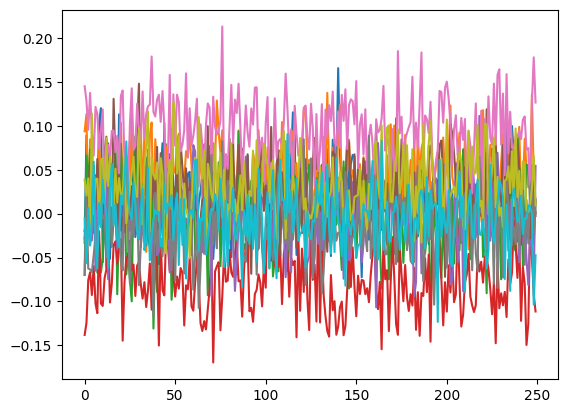

In [25]:
print(y_test_pred)
import matplotlib.pyplot as plt
plt.plot(y_test_pred[:,:10])


In [26]:
y_test

tensor([[ 50.0000,  54.4118,  13.2353,  ...,  20.5882,  48.5294,  11.7647],
        [ 35.2941,  52.9412,  14.7059,  ...,  23.5294,  32.3529,   8.8235],
        [ 50.0000,  52.9412,  11.7647,  ...,  14.7059,  55.8824,  29.4118],
        ...,
        [ 47.0588,  48.0392,   7.8431,  ...,  39.2157,  45.0980,  41.1765],
        [ 88.2353, 119.1176,  17.6471,  ...,  98.5294,  39.7059,  35.2941],
        [ 52.9412,  32.3529,   8.8235,  ...,  50.0000,  41.1765,  23.5294]])